# Loading necessary packages

In [1]:
from os.path import isdir
from os import mkdir
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from tqdm import tqdm

# Setting up device

In [2]:
device_id=0
torch.cuda.set_device(device_id)
device='cuda:'+str(device_id)

# Data preparation

## Load MNIST dataset

In [3]:
datapath='./datasets'
if not isdir(datapath):
    mkdir(datapath)

mnist_train=datasets.MNIST(datapath, train= True, download = True)
x_train=mnist_train.data
y_train=mnist_train.targets
mnist_test=datasets.MNIST(datapath, train= False, download = True)
x_test=mnist_test.data
y_test=mnist_test.targets

x_train=x_train.reshape(x_train.shape[0],-1)
x_test=x_test.reshape(x_test.shape[0],-1)

## Create Permuted MNIST

In [4]:

num_task=20
step=100
init=100

seeds=np.arange(init,num_task*step+init,step)
n_class=len(np.unique(y_train))
train_y=np.zeros((len(y_train),n_class))
for i in range(train_y.shape[0]):
    train_y[i,y_train[i]]=1
test_y=np.zeros((len(y_test),n_class))
for i in range(test_y.shape[0]):
    test_y[i,y_test[i]]=1
    
data=[[x_train,train_y]]
data_test=[[x_test,test_y]]

pixels=np.arange(x_train.shape[1])

pixel_set=[pixels]
for task in range(num_task-1):
    np.random.seed(seeds[task])
    np.random.shuffle(pixels)
    pixel_set.append(pixels)
    
    
    x=x_train[:,pixels]    
    data.append([x,train_y])
    
    x=x_test[:,pixels]    
    data_test.append([x,test_y])
    
X_train, X_test = [], []
Y_train, Y_test = [], []


for task in range(num_task):
    X_currTask_train=data[task][0].numpy()
    Y_currTask_train=data[task][1]
    X_currTask_test=data_test[task][0].numpy()
    Y_currTask_test=data_test[task][1]

    X_train.append(X_currTask_train) 
    X_test.append(X_currTask_test) 
    Y_train.append(Y_currTask_train)
    Y_test.append(Y_currTask_test) 
X_train = np.asarray(X_train)
X_train = np.reshape(X_train,(num_task,X_train.shape[1],X_train.shape[2])) 
X_test = np.asarray(X_test)
X_test = np.reshape(X_test,(num_task,X_test.shape[1],X_test.shape[2])) 
Y_train = np.asarray(Y_train)
Y_train = np.reshape(Y_train,(num_task,Y_train.shape[1],Y_train.shape[2])) 
Y_test = np.asarray(Y_test)
Y_test = np.reshape(Y_test,(num_task,Y_test.shape[1],Y_test.shape[2])) 
print(X_train.shape)

(20, 60000, 784)


# Hyperparameters

In [5]:
# Parameters:
num_task=20
n_class=10 # Ouput dimension

# Selection of r1, r2:
r1= 11
r2= 1

batch_size=128
# Epochs by task (task1, task2, task3 ....):

train_epochs=[500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500]

lr_base = 1e-5
lr_cont = 1e-4




# Network (3 layer MLP)

In [6]:
# Layers def:
relu = torch.nn.ReLU()
# sigmoid=torch.nn.Sigmoid()
softmax=torch.nn.Softmax(dim=1)
mse_loss = torch.nn.MSELoss(reduction='mean')

w_task=[]
for task in range(num_task):

    if task==0:
        r=r1
        lr = lr_base
    else:
        r=r2
        lr = lr_cont


    # Initialize weights
    #Layer 1
    wR1 = torch.empty(x_train.shape[1], r).to(device)
    wL1 = torch.empty(256, r).to(device)
    s1 = torch.ones(r).to(device)
    b1 = torch.zeros(256).to(device)
    #Layer 2
    wR2 = torch.empty(256, r).to(device)
    wL2 = torch.empty(256, r).to(device)
    s2 = torch.ones(r).to(device)
    b2 = torch.zeros(256).to(device)
    #layer 3
    w3=torch.empty(256, n_class).to(device)
    b3 = torch.zeros(n_class).to(device)

    # Initialization:
    torch.nn.init.orthogonal_(wR1)
    torch.nn.init.orthogonal_(wL1)
    torch.nn.init.orthogonal_(wR2)
    torch.nn.init.orthogonal_(wL2)
    torch.nn.init.orthogonal_(w3)

    w_task.append([wR1,wL1,wR2,wL2,w3,s1,s2,b1,b2,b3])

# Training

Task Progress:


  0%|                                                    | 0/20 [00:00<?, ?it/s]

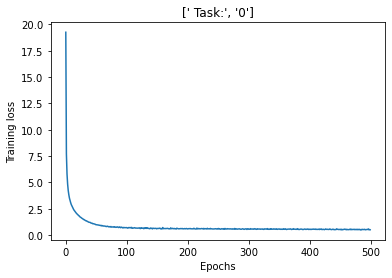

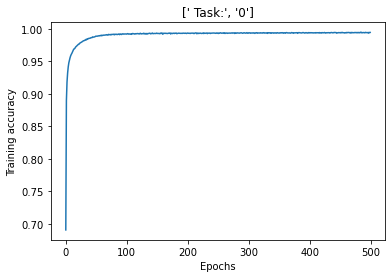

  5%|██                                       | 1/20 [14:48<4:41:17, 888.29s/it]

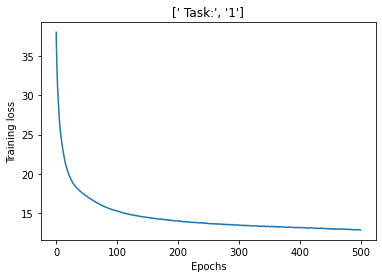

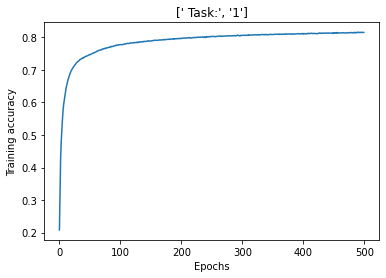

 10%|████                                     | 2/20 [30:13<4:32:58, 909.91s/it]

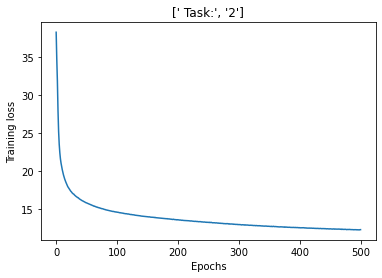

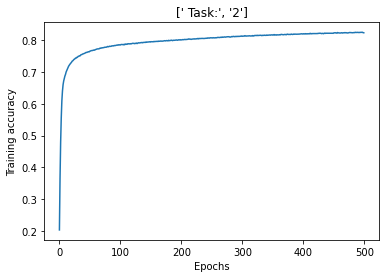

 15%|██████▏                                  | 3/20 [44:57<4:14:26, 898.05s/it]

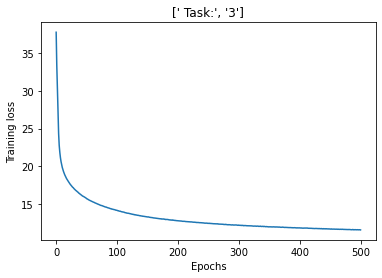

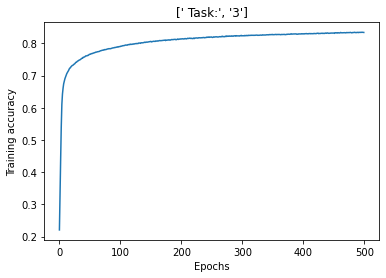

 20%|███████▊                               | 4/20 [1:04:02<4:25:29, 995.62s/it]

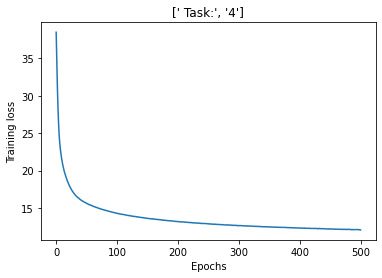

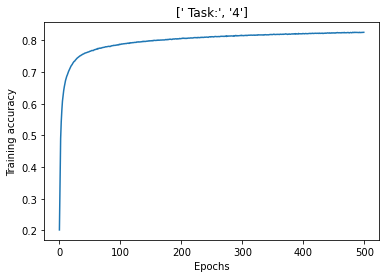

 25%|█████████▌                            | 5/20 [1:23:37<4:25:07, 1060.49s/it]

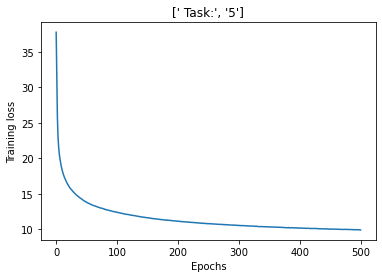

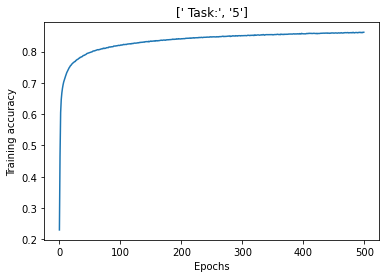

 30%|███████████▍                          | 6/20 [1:43:21<4:17:14, 1102.47s/it]

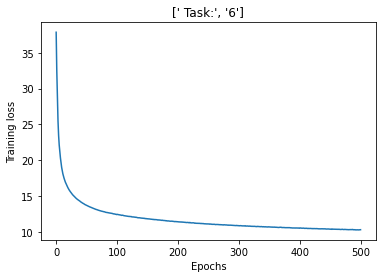

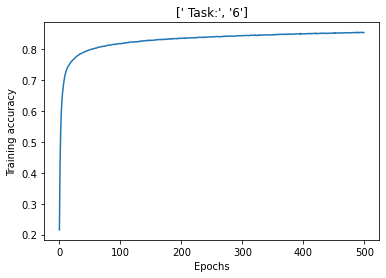

 35%|█████████████▎                        | 7/20 [2:03:10<4:04:57, 1130.60s/it]

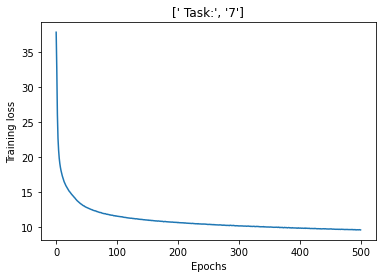

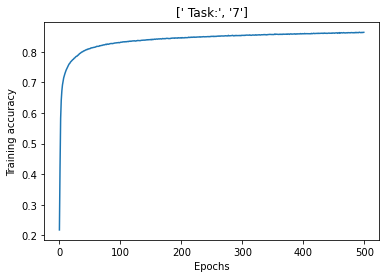

 40%|███████████████▏                      | 8/20 [2:22:54<3:49:31, 1147.66s/it]

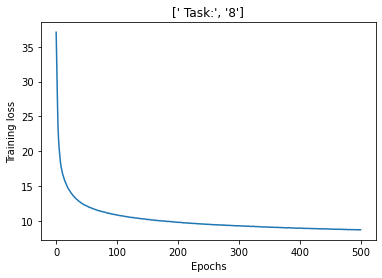

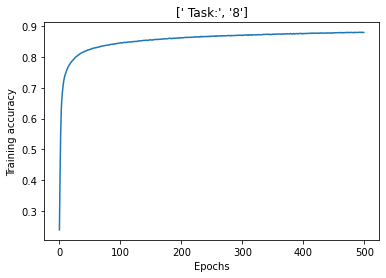

 45%|█████████████████                     | 9/20 [2:42:31<3:32:05, 1156.82s/it]

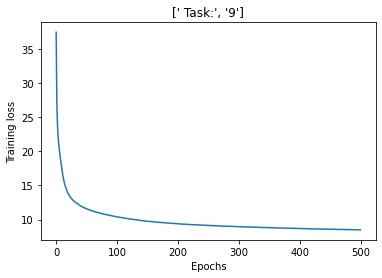

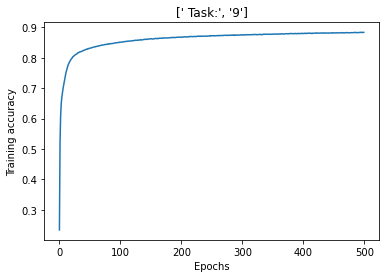

 50%|██████████████████▌                  | 10/20 [3:02:17<3:14:16, 1165.67s/it]

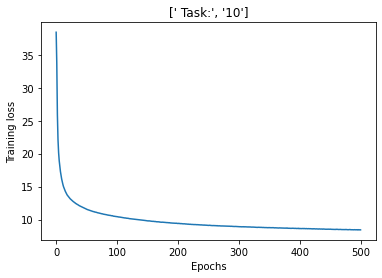

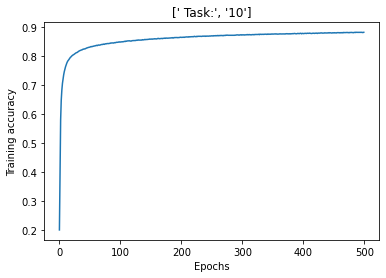

 55%|████████████████████▎                | 11/20 [3:22:04<2:55:50, 1172.27s/it]

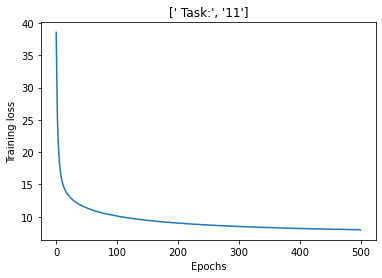

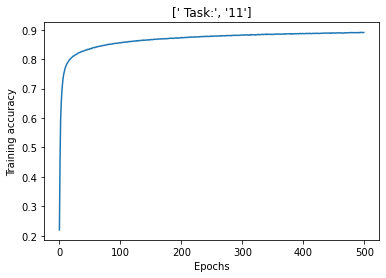

 60%|██████████████████████▏              | 12/20 [3:41:50<2:36:53, 1176.64s/it]

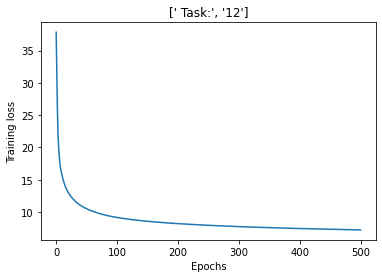

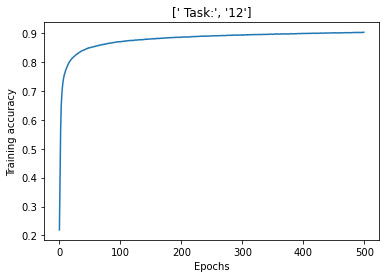

 65%|████████████████████████             | 13/20 [4:01:40<2:17:43, 1180.50s/it]

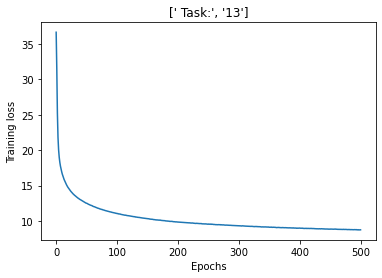

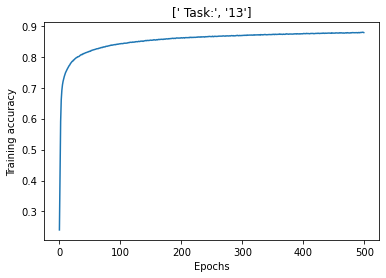

 70%|█████████████████████████▉           | 14/20 [4:21:27<1:58:15, 1182.60s/it]

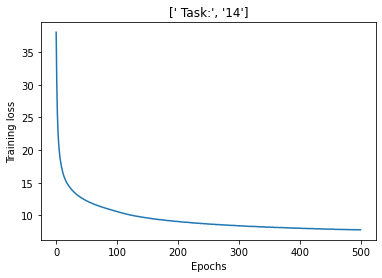

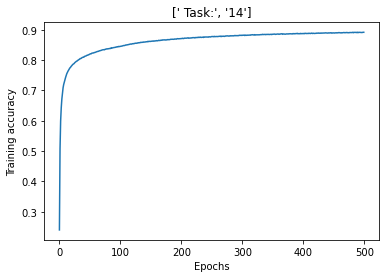

 75%|███████████████████████████▊         | 15/20 [4:41:11<1:38:34, 1182.86s/it]

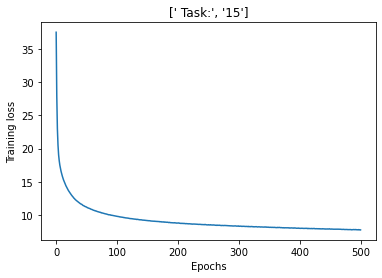

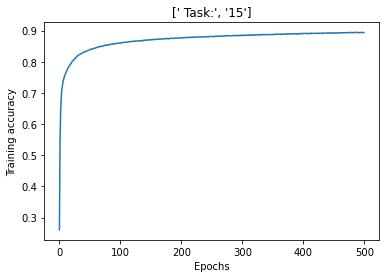

 80%|█████████████████████████████▌       | 16/20 [5:00:54<1:18:52, 1183.03s/it]

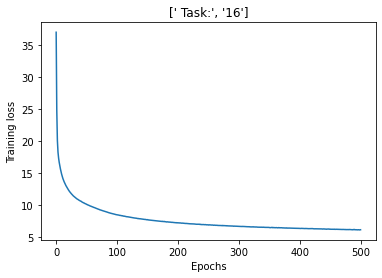

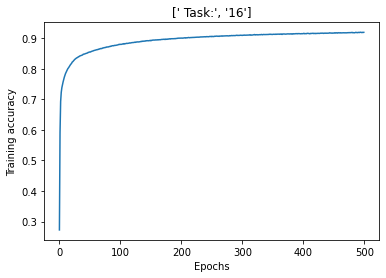

 85%|█████████████████████████████████▏     | 17/20 [5:20:43<59:13, 1184.63s/it]

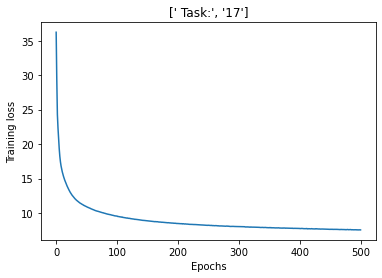

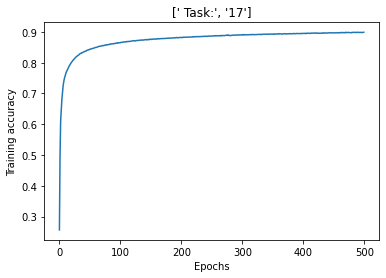

 90%|███████████████████████████████████    | 18/20 [5:40:27<39:29, 1184.59s/it]

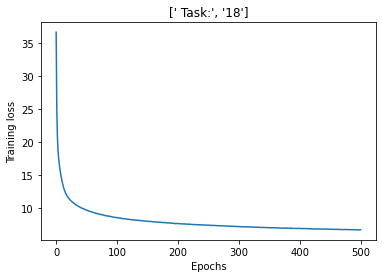

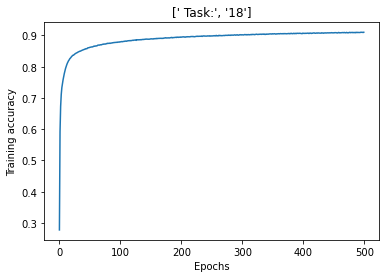

 95%|█████████████████████████████████████  | 19/20 [6:00:16<19:46, 1186.01s/it]

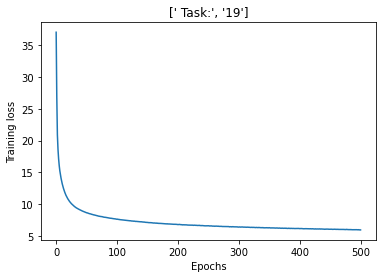

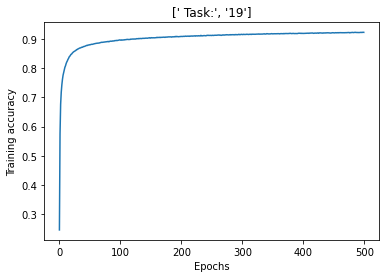

100%|███████████████████████████████████████| 20/20 [6:20:03<00:00, 1140.17s/it]


In [7]:

# Train-Test sequence:
print("Task Progress:")
# Train
U_, S_, V_ = [],[],[]
U_.append(w_task[0][0]); U_.append(w_task[0][2]) # U_[n], n-th interm layer.
S_.append(w_task[0][5]); S_.append(w_task[0][6]) # s0
V_.append(w_task[0][1]); V_.append(w_task[0][3]) # wL0
S1_tasks = []
S2_tasks = []
b_tasks = []
w3_tasks = []
for task in tqdm(range(num_task)):

    dwR1=torch.autograd.Variable(w_task[task][0],requires_grad=True)
    dwL1=torch.autograd.Variable(w_task[task][1],requires_grad=True)
    dwR2=torch.autograd.Variable(w_task[task][2],requires_grad=True)
    dwL2=torch.autograd.Variable(w_task[task][3],requires_grad=True)    
    w3=torch.autograd.Variable(w_task[task][4],requires_grad=True)
    # Selector
    if task == 0:
        ds1 = torch.autograd.Variable(w_task[task][5],requires_grad=True)
        ds2 = torch.autograd.Variable(w_task[task][6],requires_grad=True)  
    else:
        ds1 = torch.cat((torch.zeros(S1_tasks[task-1].shape).to(device), w_task[task][5]), dim = 0) 
        ds2 = torch.cat((torch.zeros(S2_tasks[task-1].shape).to(device), w_task[task][6]), dim = 0)      
        ds1=torch.autograd.Variable(ds1,requires_grad=True)
        ds2=torch.autograd.Variable(ds2,requires_grad=True)
    # Bias
    b1=torch.autograd.Variable(w_task[task][7],requires_grad=True)
    b2=torch.autograd.Variable(w_task[task][8],requires_grad=True)
    b3=torch.autograd.Variable(w_task[task][9],requires_grad=True)

    optimizer=torch.optim.Adam([dwR1,dwL1,dwR2,dwL2,w3,ds1,ds2,b1,b2,b3],lr=lr)
    #optimizer=torch.optim.SGD([dwR1,dwL1,dwR2,dwL2,w3,ds1,ds2,b1,b2,b3],lr=lr,momentum = 0.9)

    loss_epoch=[]

    epoch_correct, epoch_total = 0, 0
    epoch_accuracy = []
    times = 1
    for epoch in range(train_epochs[task]):
        train_size=len(X_train[task])
        batch_no=np.int16(np.ceil(train_size/np.float64(batch_size)))

        epoch_idx=np.arange(train_size)
        np.random.shuffle(epoch_idx)


        loss_batch = 0
        for batch_idx in range(0, batch_no):
            x_batch=X_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size,train_size])],:]
            y_batch=Y_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size,train_size])]]

            x_batch_tensor=torch.FloatTensor(x_batch).to(device)
            y_batch_tensor=torch.FloatTensor(y_batch).to(device)

            if task == 0:
                w1=torch.matmul(torch.matmul(dwR1,torch.diag(ds1)),dwL1.T)
                w2=torch.matmul(torch.matmul(dwR2,torch.diag(ds2)),dwL2.T)
            else:
                U_inc1 = torch.cat((U_[0].to(device), dwR1), dim = 1)
                V_inc1 = torch.cat((V_[0].to(device), dwL1), dim = 1)
                w1=torch.matmul(torch.matmul(U_inc1,torch.diag(ds1)),V_inc1.T)

                U_inc2 = torch.cat((U_[1].to(device), dwR2), dim = 1)
                V_inc2 = torch.cat((V_[1].to(device), dwL2), dim = 1)
                w2=torch.matmul(torch.matmul(U_inc2,torch.diag(ds2)),V_inc2.T)

            h1=relu(torch.matmul(x_batch_tensor,w1)+b1)
            h2=relu(torch.matmul(h1,w2)+b2)

            y_hat=softmax(torch.matmul(h2,w3)+b3)

            loss=mse_loss(y_hat,y_batch_tensor)

            loss_batch = loss_batch + loss.item()


            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            # Prediction:
            prediction = np.argmax(y_hat.cpu().detach().numpy(),axis=1)
            y_label=np.argmax(y_batch_tensor.cpu().detach().numpy(),axis=1)
            epoch_correct += int(sum(y_label == prediction))
            epoch_total += int(len(y_label))

        epoch_accuracy.append(float(epoch_correct / epoch_total))
        epoch_correct, epoch_total = 0, 0

        loss_epoch.append(loss_batch)

    # Concatenate the weight matrix of every tasks:
    with torch.no_grad():
        if task == 0:
            U_[0] = dwR1.detach(); U_[1] = dwR2.detach()
            S_[0] = ds1.detach(); S_[1] = ds2.detach()
            V_[0] = dwL1.detach(); V_[1] = dwL2.detach()
        elif task >= 1:
            U_[0] = torch.cat((U_[0], dwR1.detach()), dim = 1); U_[1] = torch.cat((U_[1], dwR2.detach()), dim = 1)
            S_[0] = ds1; S_[1] = ds2
            V_[0] = torch.cat((V_[0], dwL1.detach()), dim = 1); V_[1] = torch.cat((V_[1], dwL2.detach()), dim = 1)

        # Save selector matrices of every tasks:
        S1_tasks.append(ds1); S2_tasks.append(ds2)
        b_tasks.append([b1.detach(), b2.detach(), b3.detach()])
        w3_tasks.append(w3.detach())

    # Plot loss:
    plt.figure()
    plt.plot(loss_epoch)
    plt.title([' Task:',str(task)])
    plt.xlabel('Epochs')
    plt.ylabel('Training loss')
    plt.show()
    # Plot epoch accuracy:
    plt.figure()
    plt.plot(epoch_accuracy)
    plt.title([' Task:',str(task)])
    plt.xlabel('Epochs')
    plt.ylabel('Training accuracy')
    plt.show()

    with torch.no_grad():
        w_task[task][0]=dwR1.detach()
        w_task[task][1]=dwL1.detach()
        w_task[task][2]=dwR2.detach()
        w_task[task][3]=dwL2.detach()
        w_task[task][4]=w3.detach()
        w_task[task][5]=ds1.detach()
        w_task[task][6]=ds2.detach()
        w_task[task][7]=b1.detach()  
        w_task[task][8]=b2.detach()  
        w_task[task][9]=b3.detach()


final_weights = [U_, V_, S1_tasks, S2_tasks, b_tasks, w3_tasks]

# Inference

## On the test set

In [8]:

test_accuracy=[]
for task in range(num_task):

    test_correct, test_total = 0, 0
    with torch.no_grad():
        test_size=len(X_test[task])
        batch_no=np.int16(np.ceil(test_size/np.float64(batch_size)))

        epoch_idx=np.arange(test_size)
        np.random.shuffle(epoch_idx)

        for batch_idx in range(0, batch_no):
            x_batch=X_test[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size,test_size])],:]
            y_batch=Y_test[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size,test_size])]]

            x_batch_tensor=torch.FloatTensor(x_batch).to(device)
            y_batch_tensor=torch.FloatTensor(y_batch).to(device)

            u_1 = U_[0][:,0:r1+(task)*r2]
            s_1 = S1_tasks[task]
            v_1 = V_[0][:,0:r1+(task)*r2]
            u_2 = U_[1][:,0:r1+(task)*r2]
            s_2 = S2_tasks[task]
            v_2 = V_[1][:,0:r1+(task)*r2]
            w1=torch.matmul(torch.matmul(u_1, torch.diag(s_1)),v_1.T)
            w2=torch.matmul(torch.matmul(u_2, torch.diag(s_2)),v_2.T)


            h1=relu(torch.matmul(x_batch_tensor,w1) + b_tasks[task][0])

            h2=relu(torch.matmul(h1,w2) + b_tasks[task][1])

            # Prediction
            w3 = w3_tasks[task]
            y_hat=softmax(torch.matmul(h2,w3) + b_tasks[task][2])
            prediction = np.argmax(y_hat.cpu().detach().numpy(),axis=1)
            y_label=np.argmax(y_batch_tensor.cpu().detach().numpy(),axis=1)
            test_correct += int(sum(y_label == prediction))
            test_total += int(len(y_label))

    test_accuracy.append(float(test_correct / test_total))


print("Test Accuracy: ", test_accuracy, "Avg: ", np.mean(test_accuracy))

Test Accuracy:  [0.9645, 0.7908, 0.7985, 0.8157, 0.8067, 0.8402, 0.8288, 0.8414, 0.8632, 0.8542, 0.8546, 0.8622, 0.8761, 0.8521, 0.8622, 0.8667, 0.8837, 0.8679, 0.8832, 0.887] Avg:  0.8549849999999999


## On the training set

In [9]:

train_accuracy=[]
for task in range(num_task):

    train_correct, train_total = 0, 0
    with torch.no_grad():
        train_size=len(X_train[task])
        batch_no=np.int16(np.ceil(train_size/np.float64(batch_size)))

        epoch_idx=np.arange(train_size)
        np.random.shuffle(epoch_idx)

        for batch_idx in range(0, batch_no):
            x_batch=X_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size,train_size])],:]
            y_batch=Y_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size,train_size])]]

            x_batch_tensor=torch.FloatTensor(x_batch).to(device)
            y_batch_tensor=torch.FloatTensor(y_batch).to(device)


            u_1 = U_[0][:,0:r1+(task)*r2]
            s_1 = S1_tasks[task]
            v_1 = V_[0][:,0:r1+(task)*r2]
            u_2 = U_[1][:,0:r1+(task)*r2]
            s_2 = S2_tasks[task]
            v_2 = V_[1][:,0:r1+(task)*r2]

            w1=torch.matmul(torch.matmul(u_1, torch.diag(s_1)),v_1.T)
            w2=torch.matmul(torch.matmul(u_2, torch.diag(s_2)),v_2.T)

            h1=relu(torch.matmul(x_batch_tensor,w1) + b_tasks[task][0])

            h2=relu(torch.matmul(h1,w2) + b_tasks[task][1])

            # Prediction
            w3 = w3_tasks[task]
            y_hat=softmax(torch.matmul(h2,w3) + b_tasks[task][2]) # Multi-class

            prediction = np.argmax(y_hat.cpu().detach().numpy(),axis=1) # Multi-class
            y_label=np.argmax(y_batch_tensor.cpu().detach().numpy(),axis=1) # Multi-class
            train_correct += int(sum(y_label == prediction)) # Multi-class
            train_total += int(len(y_label)) # Multi-class

    train_accuracy.append(float(train_correct / train_total))
print("Training Accuracy: ", train_accuracy, "Avg: ", np.mean(train_accuracy))

Training Accuracy:  [0.9939833333333333, 0.8154833333333333, 0.8205333333333333, 0.8361833333333333, 0.8269666666666666, 0.8632333333333333, 0.8565333333333334, 0.8656, 0.8810833333333333, 0.8824333333333333, 0.8854166666666666, 0.8921166666666667, 0.90455, 0.8800166666666667, 0.8932666666666667, 0.8964166666666666, 0.9187, 0.9001833333333333, 0.9092833333333333, 0.9243] Avg:  0.8823141666666666
